In [2]:
import os, sys, time, errno
import numpy as np
import scipy as sp
import mvpa2.suite as mvpa2

add_delay = 6
TR = 2.3

output_path = 'output'
offset = 5

In [3]:
def read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,brightness_file,nTRs=2):
    
    ds = mvpa2.fmri_dataset(data_file,mask=mask_file,add_fa={'cluster':mask_file})

    log = np.recfromcsv(log_file,delimiter=',')

    with open(nuisance_file) as f:
        nuisance = f.readlines()
    reg1 = []
    reg2 = []
    for nuisance_line in nuisance:
        a = nuisance_line.split(' ')
        if len(a) == 2:
            reg1.append(float(a[0]))
            reg2.append(float(a[1]))

    with open(brightness_file) as f:
        brightness = f.readlines()
    brightness_reg = [float(b) for b in brightness]
    
    ds.sa['reg1']=reg1
    ds.sa['reg2']=reg2
    ds.sa['brightness']=brightness_reg
    ds.sa['timepoint'] = TR * np.arange(len(ds))
    ds.sa['chunks'] = [0 for i in range(len(ds))]
    #ds.sa['zscore_chunk'] = [0 for i in range(len(ds))]
    
    ## Regress away nuisance regressors (white-matter and background noise)
    ds = ds[offset:]

    opt_regs = ['reg1','reg2']
    for i in range(1,np.max(log.session)+1):
        chunks_marker = np.zeros(len(ds))

        min_t = np.min(log.onset[log.session == i])
        max_t = np.max(log.onset[log.session == i]) + 15
        
        ds.sa.chunks[(ds.sa.timepoint >= min_t) & (ds.sa.timepoint < max_t)] = i
        #ds.sa.zscore_chunk[(ds.sa.timepoint >= min_t) & (ds.sa.timepoint < max_t)] = 1
        #chunks_marker[(ds.sa.timepoint >= min_t) & (ds.sa.timepoint < max_t)] = 1
        #ds.sa['chunk'+str(i)] = chunks_marker
        #opt_regs.append('chunk'+str(i))

    #mvpa2.poly_detrend(ds,chunks_attr='chunks',polyord=1,opt_regs=opt_regs)
    mvpa2.poly_detrend(ds,polyord=1,opt_regs=opt_regs)
    mvpa2.zscore(ds,chunks_attr=None)
    #mvpa2.zscore(ds,chunks_attr='zscore_chunk')

    ## Select all the scans where the pictures are shown (onset+6s)
    scans = np.round((log.onset + add_delay) / TR).astype(int) - offset

    # First
    ds_extracted = [ds[scans+nTR].copy(deep=True) for nTR in range(nTRs)]
    
    for ds_e in ds_extracted:
        ds_e.sa['chunks'] = log.session
        ds_e.sa['category'] = log.category    
        ds_e.sa['brightness'] = log.brightness
        #mvpa2.poly_detrend(ds_e,polyord=0,opt_regs=['brightness'])
    
    for i in range(1,nTRs):
        ds_extracted[0].samples = ds_extracted[0].samples + ds_extracted[i].samples

    ds1 = ds_extracted[0]
    ds1 = ds1[np.argsort(log.picture)]
    
    #dm = PolyDetrendMapper(chunks_attr=None, polyord=0, opt_regs=['brightness'])
    #ds1 = dm.forward(ds)

    sample_mean = np.mean(ds1,axis=1)
    for i,s in enumerate(sample_mean):
        ds1.samples[i,:] -= s
    
    return ds1

SPM version

In [4]:
import glob 

method = 'normalized_spm'
method0 = method.split('_')[0]
method1 = method.split('_')[1]

for nTR in range(3,4):
    vsize = []
    allsubjs = np.array(range(4,42))
    accuracy = []

    for subj in allsubjs:

        ## For each subject    
        start_time = time.time()

        data_file = glob.glob('../spm/'+method0+'/picture/S'+str(subj)+'/T'+str(nTR)+'/beta*.nii')[:112]

        if method1 == 'wholebrain':
            mask_file = '../roi/normalized/cortex-mask.nii.gz'
        elif method1 == "spm":
            mask_file = '../roi/normalized/common_mask/picture_thres2.nii'
        elif method1 == "common":
            if method0 == "native":
                mask_file = '../roi/'+method0+'/common_mask/'+r+'/S'+str(subj)+'/w'+r+'.nii'
            else:
                mask_file = '../roi/'+method0+'/common_mask/'+r+'.nii.gz'
        else:
            mask_file = '../roi/'+method0+'/'+r+'/S'+str(subj)+'.nii'

        log_file = '../log/S'+str(subj)+'_picture.csv'

        ds = mvpa2.fmri_dataset(data_file,mask=mask_file)
        log = np.recfromcsv(log_file,delimiter=',')
        ds.sa['category']=sorted(log.category)
        ds.sa['chunks']=log.session[np.argsort(log.picture)]

        elapsed_time = time.time() - start_time

        clf = mvpa2.LinearCSVMC(space='category')
        cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
        res = cv(ds)

        accuracy.append(np.mean(res))
        print "Subject "+str(subj)+" "+str(ds.shape)+" Accuracy: "+str(np.mean(res))+\
                " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'

    accuracy = np.array(accuracy)
    mask = (np.arange(4,42) != 8)

    print "Mean = "+str(np.mean(accuracy[mask]))
    print "SD = "+str(np.std(accuracy[mask]))
    print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

 * Please note: warnings are printed only once, but underlying problem might occur many times *
Subject 4 (112, 3173) Accuracy: 0.589285714286 Elapsed time: 5.64s
Subject 5 (112, 3173) Accuracy: 0.616071428571 Elapsed time: 11.02s
Subject 6 (112, 3173) Accuracy: 0.651785714286 Elapsed time: 5.93s
Subject 7 (112, 3173) Accuracy: 0.544642857143 Elapsed time: 6.62s
Subject 8 (112, 3173) Accuracy: 0.392857142857 Elapsed time: 3.16s
Subject 9 (112, 3173) Accuracy: 0.571428571429 Elapsed time: 8.70s
Subject 10 (112, 3173) Accuracy: 0.517857142857 Elapsed time: 7.82s
Subject 11 (112, 3173) Accuracy: 0.473214285714 Elapsed time: 8.40s
Subject 12 (112, 3173) Accuracy: 0.758928571429 Elapsed time: 6.40s
Subject 13 (112, 3173) Accuracy: 0.616071428571 Elapsed time: 6.65s
Subject 14 (112, 3173) Accuracy: 0.607142857143 Elapsed time: 6.33s
Subject 15 (112, 3173) Accuracy: 0.714285714286 Elapsed time: 5.78s
Subject 16 (112, 3173) Accuracy: 0.544642857143 Elapsed time: 7.18s
Subject 17 (112, 3173) Ac

Robustness to voxel selection

In [47]:
#method = 'normalized_common'
method = 'normalized_spm'
method0 = method.split('_')[0]
method1 = method.split('_')[1]

#roi_mask = ['picture_0.5','picture_1','picture_2']
#roi_mask = ['picture_1_no_occip_clust_10']
#roi_mask = ['picture_1_clust_10','picture_2_clust_10','picture_5_clust_10']
#roi_mask = ['picture_2_clust_10_no_occip']
#roi_mask = ['picture_1_clust_10','picture_2_clust_10','picture_5_clust_10']
#roi_mask = ['wholebrain']
roi_mask = ['spm']

allsubjs = np.array(range(4,42))

for r in roi_mask:
    print r
    
    vsize = []
    
    accuracy = []
    
    for subj in allsubjs:
        
        ## For each subject    
        start_time = time.time()

        data_file = '../nifti/'+method0+'/picture/S'+str(subj)+'_picture_'+method0+'.nii'
        
        if method1 == 'wholebrain':
            mask_file = '../roi/normalized/cortex-mask.nii.gz'
        elif method1 == "spm":
            mask_file = '../roi/normalized/common_mask/spm/picture.nii'
        elif method1 == "common":
            if method0 == "native":
                mask_file = '../roi/'+method0+'/common_mask/'+r+'/S'+str(subj)+'/w'+r+'.nii'
            else:
                mask_file = '../roi/'+method0+'/common_mask/'+r+'.nii.gz'
        else:
            mask_file = '../roi/'+method0+'/'+r+'/S'+str(subj)+'.nii'
            
        log_file = '../log/S'+str(subj)+'_picture.csv'
        nuisance_file = '../nuisance/'+method0+'/S'+str(subj)+'_picture_nuisance.txt'
        brightness_file = '../nuisance/'+method0+'/S'+str(subj)+'_picture_brightness.txt'
        
        ds = read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,brightness_file)

        elapsed_time = time.time() - start_time

        clf = mvpa2.LinearCSVMC(space='category')
        cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
        res = cv(ds)
        
        accuracy.append(np.mean(res))
        print "Subject "+str(subj)+" "+str(ds.shape)+" Accuracy: "+str(np.mean(res))+\
                " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'
    
    accuracy = np.array(accuracy)
    mask = (np.arange(4,42) != 8)

    print "Mean = "+str(np.mean(accuracy[mask]))
    print "SD = "+str(np.std(accuracy[mask]))
    print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

spm
Subject 4 (112, 2922) Accuracy: 0.508928571429 Elapsed time: 1.02s
Subject 5 (112, 2922) Accuracy: 0.446428571429 Elapsed time: 1.29s
Subject 6 (112, 2922) Accuracy: 0.491071428571 Elapsed time: 0.84s
Subject 7 (112, 2922) Accuracy: 0.366071428571 Elapsed time: 0.92s
Subject 8 (112, 2922) Accuracy: 0.241071428571 Elapsed time: 1.08s
Subject 9 (112, 2922) Accuracy: 0.464285714286 Elapsed time: 0.77s
Subject 10 (112, 2922) Accuracy: 0.428571428571 Elapsed time: 1.30s
Subject 11 (112, 2922) Accuracy: 0.392857142857 Elapsed time: 1.62s
Subject 12 (112, 2922) Accuracy: 0.678571428571 Elapsed time: 0.84s
Subject 13 (112, 2922) Accuracy: 0.482142857143 Elapsed time: 0.77s
Subject 14 (112, 2922) Accuracy: 0.589285714286 Elapsed time: 0.85s
Subject 15 (112, 2922) Accuracy: 0.5625 Elapsed time: 0.92s
Subject 16 (112, 2922) Accuracy: 0.473214285714 Elapsed time: 0.81s
Subject 17 (112, 2922) Accuracy: 0.517857142857 Elapsed time: 0.78s
Subject 18 (112, 2922) Accuracy: 0.428571428571 Elapsed ti

Robustness to TR length

In [13]:
method = 'normalized_common'
method0 = method.split('_')[0]
method1 = method.split('_')[1]

#roi_mask = ['picture_0.5','picture_1','picture_2']
#roi_mask = ['picture_1_no_occip_clust_10']
#roi_mask = ['picture_1_clust_10','picture_2_clust_10','picture_5_clust_10']
#roi_mask = ['picture_2_clust_10_no_occip']
roi_mask = ['picture_2_clust_10']

allsubjs = np.array(range(4,42))

for r in roi_mask:
    print r
    for nTRs in [2,1,3,4]:
        print nTRs

        vsize = []

        accuracy = []

        for subj in allsubjs:

            ## For each subject    
            start_time = time.time()

            data_file = '../nifti/'+method0+'/picture/S'+str(subj)+'_picture_'+method0+'.nii.gz'

            if method1 == "common":
                if method0 == "native":
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'/S'+str(subj)+'/w'+r+'.nii'
                else:
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'.nii.gz'
            else:
                mask_file = '../roi/'+method0+'/'+r+'/S'+str(subj)+'.nii'

            log_file = '../log/S'+str(subj)+'_picture.csv'
            nuisance_file = '../nuisance/'+method0+'/S'+str(subj)+'_picture_nuisance.txt'

            ds = read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,nTRs)

            elapsed_time = time.time() - start_time

            clf = mvpa2.LinearCSVMC(space='category')
            cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
            res = cv(ds)

            accuracy.append(np.mean(res))
            print "Subject "+str(subj)+" "+str(ds.shape)+" Accuracy: "+str(np.mean(res))+\
                    " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'

        accuracy = np.array(accuracy)
        mask = (np.arange(4,42) != 8)

        print "Mean = "+str(np.mean(accuracy[mask]))
        print "SD = "+str(np.std(accuracy[mask]))
        print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

picture_2_clust_10
2
Subject 4 (112, 2875) Accuracy: 0.473214285714 Elapsed time: 4.34s
Subject 5 (112, 2875) Accuracy: 0.419642857143 Elapsed time: 4.52s
Subject 6 (112, 2875) Accuracy: 0.5 Elapsed time: 4.62s
Subject 7 (112, 2875) Accuracy: 0.366071428571 Elapsed time: 4.69s
Subject 8 (112, 2875) Accuracy: 0.330357142857 Elapsed time: 4.87s
Subject 9 (112, 2875) Accuracy: 0.383928571429 Elapsed time: 9.24s
Subject 10 (112, 2875) Accuracy: 0.375 Elapsed time: 9.64s
Subject 11 (112, 2875) Accuracy: 0.3125 Elapsed time: 8.67s
Subject 12 (112, 2875) Accuracy: 0.571428571429 Elapsed time: 9.58s
Subject 13 (112, 2875) Accuracy: 0.464285714286 Elapsed time: 9.28s
Subject 14 (112, 2875) Accuracy: 0.464285714286 Elapsed time: 8.96s
Subject 15 (112, 2875) Accuracy: 0.571428571429 Elapsed time: 9.51s
Subject 16 (112, 2875) Accuracy: 0.392857142857 Elapsed time: 9.18s
Subject 17 (112, 2875) Accuracy: 0.464285714286 Elapsed time: 9.06s
Subject 18 (112, 2875) Accuracy: 0.366071428571 Elapsed time:

In [9]:
accuracy = np.array(accuracy)
mask = (np.arange(4,42) != 8)

print "Mean = "+str(np.mean(accuracy[mask]))
print "SD = "+str(np.std(accuracy[mask]))
print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

Mean = 0.432432432432
SD = 0.0842841534211
Ttest_1sampResult(statistic=12.986956031056204, pvalue=3.7599995948616555e-15)


## Supplementary Analysis 3

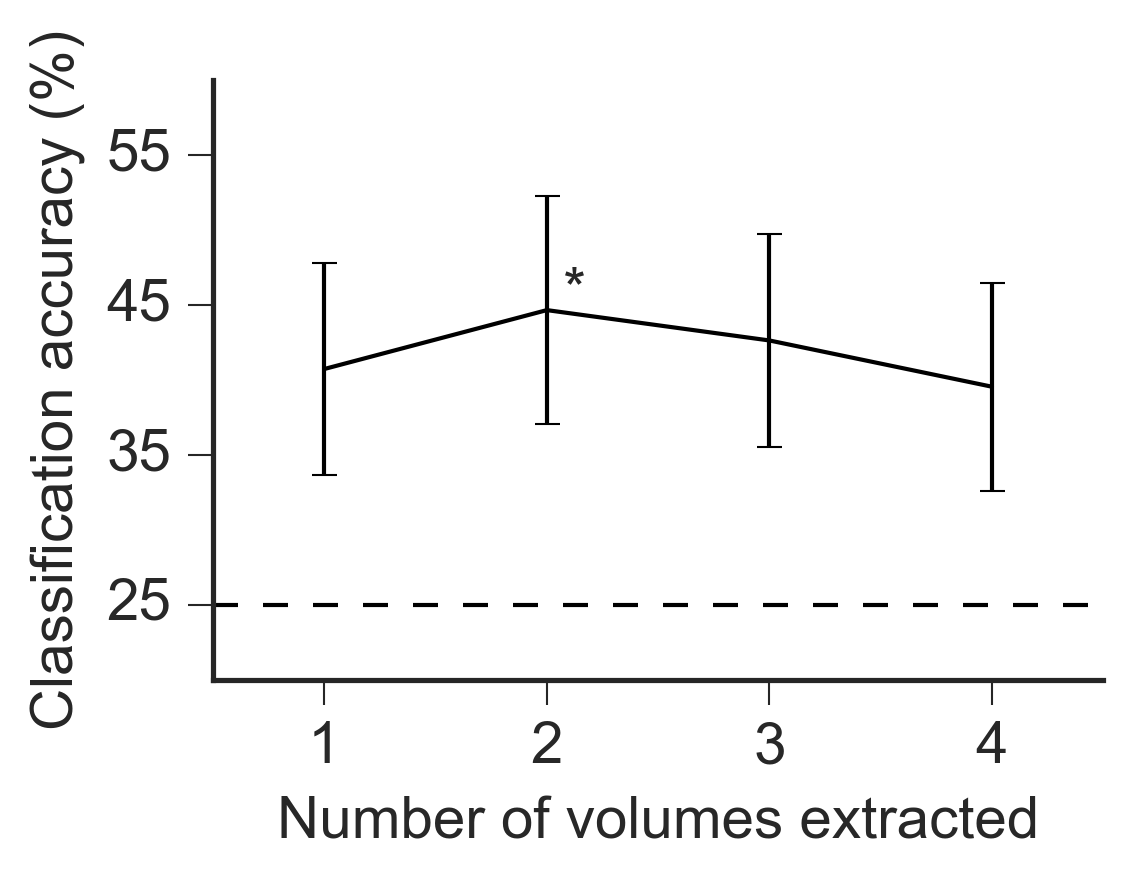

In [40]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

sns.reset_orig()
sns.set_style("ticks")
plt.rc('font', family='Arial', size=14)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)
sns.set_palette([(0.5,0.5,0.5),(0,0,0)],n_colors=1,desat=0.0)

accuracy = [0.407335907336, 0.44666988417, 0.4263996139, 0.395511583012]
SD = [0.0704674524097, 0.0762571171642,0.0713804557236,0.0693428863221]

accuracy = np.array(accuracy)*100
SD = np.array(SD)*100

plt.figure(figsize=(4,3))
plt.errorbar([1,2,3,4], accuracy, yerr=SD, color='k')
plt.xticks([1,2,3,4])
plt.xlim([0.5,4.5])
plt.ylim([20,60])
plt.yticks([25,35,45,55])
plt.annotate(' *',xy=(2,accuracy[1]))
plt.tick_params(top='off', right='off')
plt.axes().spines['right'].set_visible(False)
plt.axes().spines['top'].set_visible(False)
plt.ylabel('Classification accuracy (%)')
plt.xlabel('Number of volumes extracted')
plt.plot([0.5,4.5],[25,25],'k--')
plt.tight_layout()
plt.savefig('number_of_TR.png',fmt='png')
plt.show()
